## 6- SMOTE modeling experiment 1 - Logistic regression model
* Using baseline dataset but with applying __SMOTE__ on train set.
* Grid search will be applied to find the best-performing hyperparameter combination.
    * Model will be __fit__ on the __train__ set.
    * The __validation__ set will be used to pick the best-performing hyperparameter combination (via PredefinedSplit).
    * Final evaluation will be done on the __test__ set.
    * When using Predefined Split, the refit parameter for GridSearchCV has to be False in order for scoring to happen on df_val records.
        * When refit is False, the GridSearchCV.best_estimator_ model object is not available .
        * As such, a final fit will occur on the best-peforming hyperparameters on the train set only to get the final model.

#### Stages
1. __Reading data__.
2. __Applying SMOTE to train set__.
3. __Preparing data__.
4. __Grid search model training__.
5. **Fitting model on best parameters (cv.best_estimator_ not available)**.
6. __Model evaluation__.
7. __Feature importances__.
8. __Saving model__.

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold  # for splitting into train/val/test based on customer id while keeping fraud ratio the same for the three sets
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import (
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    average_precision_score, 
    confusion_matrix, 
    classification_report
)
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE 

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
RANDOM_SEED = 420
np.random.seed(RANDOM_SEED)

### 1- Reading data

In [3]:
train_df = pd.read_csv("data/train_baseline.csv")
val_df = pd.read_csv("data/validation_baseline.csv")
test_df = pd.read_csv("data/test_baseline.csv")

In [4]:
train_df.shape

(476608, 30)

In [5]:
train_df.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.303248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,0.018468,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.098661,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,-0.186943,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,-0.017797,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [6]:
val_df.shape

(60291, 30)

In [7]:
val_df.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.020728,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,-0.168078,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.071645,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,-0.234106,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,0.622063,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
test_df.shape

(57744, 30)

In [9]:
test_df.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.048201,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,-0.068440,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.184287,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,0.027718,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,0.457954,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


### 2- Preparing data and Applying SMOTE to train set

In [10]:
target_column = "fraud"

In [11]:
feature_columns = [column for column in train_df.columns if column != target_column]

In [12]:
feature_columns

['step',
 'amount',
 'age_0',
 'age_1',
 'age_2',
 'age_3',
 'age_4',
 'age_5',
 'age_6',
 'age_U',
 'gender_E',
 'gender_F',
 'gender_M',
 'gender_U',
 'category_es_barsandrestaurants',
 'category_es_contents',
 'category_es_fashion',
 'category_es_food',
 'category_es_health',
 'category_es_home',
 'category_es_hotelservices',
 'category_es_hyper',
 'category_es_leisure',
 'category_es_otherservices',
 'category_es_sportsandtoys',
 'category_es_tech',
 'category_es_transportation',
 'category_es_travel',
 'category_es_wellnessandbeauty']

In [13]:
X_train = train_df[feature_columns].copy()
y_train = train_df[target_column].astype(int).copy()

#### Applying SMOTE to train set

In [14]:
smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=10)

In [15]:
X_train.shape

(476608, 29)

In [16]:
y_train.shape

(476608,)

In [17]:
y_train.value_counts().to_frame()

,count
fraud,
0,470978
1,5630


In [18]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [19]:
X_train.shape

(941956, 29)

In [20]:
y_train.shape

(941956,)

In [21]:
y_train.value_counts().to_frame()

,count
fraud,
0,470978
1,470978


In [22]:
X_train.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty
0,-1.858796,-0.303248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.858796,0.018468,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.858796,-0.098661,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.858796,-0.186943,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.858796,-0.017797,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Preparing val and test sets

In [23]:
X_val = val_df[feature_columns].copy()
y_val = val_df[target_column].astype(int).copy()

In [24]:
X_test = test_df[feature_columns].copy()
y_test = test_df[target_column].astype(int).copy()

In [25]:
# Combine train and val (PredefinedSplit for specifying the val set indices as the validation set for GridSearchCV)
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)

In [26]:
# mark df_val rows as the single validation fold
test_fold = np.r_[
    -1 * np.ones(len(X_train), dtype=int),  # -1 => always train
     0 * np.ones(len(X_val),   dtype=int)  #  0 => the held-out validation fold
]

In [27]:
predefined_split = PredefinedSplit(test_fold)

In [28]:
print("PredefinedSplit sizes -> train:", (test_fold == -1).sum(), " val:", (test_fold == 0).sum())

PredefinedSplit sizes -> train: 941956  val: 60291


### 3- Grid search model training

In [29]:
model = LogisticRegression()

In [30]:
param_grid = {
    "random_state": [RANDOM_SEED],
    "penalty": [None, "l1", "l2", "elasticnet"],
    "C": [0.01, 0.1, 1.0, 10.0],
    "class_weight": [None, "balanced"],
    "solver": ["lbfgs", "liblinear"]
}

In [31]:
# Number of combinations
pg = ParameterGrid(param_grid)
print(f"Number of combinations: {len(pg)}")

Number of combinations: 64


In [32]:
cv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="f1",
    cv=predefined_split, # use df_val as the single validation fold
    n_jobs=-1, # Use all cpus
    refit=False
)

In [33]:
%%time

cv.fit(X, y)

CPU times: user 803 ms, sys: 582 ms, total: 1.39 s
Wall time: 57.7 s


,estimator,LogisticRegression()
,param_grid,"{'C': [0.01, 0.1, ...], 'class_weight': [None, 'balanced'], 'penalty': [None, 'l1', ...], 'random_state': [420], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,False
,cv,"PredefinedSpl......, 0, 0]))"
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [34]:
print(f"Best parameters: {cv.best_params_}")

Best parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'random_state': 420, 'solver': 'liblinear'}


In [35]:
print(f"f1-score of best parameters: {cv.cv_results_["mean_test_score"][cv.best_index_]}")

f1-score of best parameters: 0.20778128286014722


### 4- Fitting model on best parameters (cv.best_estimator_ not available)

In [36]:
model = LogisticRegression(n_jobs=-1).set_params(**cv.best_params_)

In [37]:
model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.01
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,420
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [38]:
%%time

model.fit(X_train, y_train)

CPU times: user 1.33 s, sys: 126 ms, total: 1.46 s
Wall time: 1.45 s


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.01
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,420
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [39]:
model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.01
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,420
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


### 5- Model evaluation

In [40]:
def evaluate_model(model, X, y, name="model"):
    # predictions
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
    else:
        scores = model.predict(X)
        
    preds = (scores >= 0.5).astype(int)

    # metrics
    metrics = {
        "accuracy": accuracy_score(y, preds),
        "precision": precision_score(y, preds, zero_division=0),
        "recall": recall_score(y, preds, zero_division=0),
        "f1": f1_score(y, preds, zero_division=0),
        "roc_auc": roc_auc_score(y, scores) if len(np.unique(y)) > 1 else np.nan,
        "avg_precision": average_precision_score(y, scores),
        "classification_report": classification_report(y, preds, digits=3)
    }
    print(f"\n{name} — metrics\n")
    for k in ["accuracy", "precision", "recall", "f1", "roc_auc", "avg_precision"]:
        v = metrics[k]
        print(f"{k:>14}: {v:.4f}" if v==v else f"{k:>14}: nan")
    print("\nClassification report:\n", metrics["classification_report"])
    
    # confusion matrix
    cm = confusion_matrix(y, preds, labels=[0, 1])
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm,
        fmt="d",
        cbar=True,
        annot=True,
        xticklabels=("Non_Fraudulent", "Fraudulent"),
        yticklabels=("Non_Fraudulent", "Fraudulent"),
        ax=ax,
        cmap="cividis"
    )
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()
    return metrics

#### 5.1- Evaluation on validation set


SMOTE Experiment - Logistic Regression Validation Set — metrics

      accuracy: 0.9375
     precision: 0.1162
        recall: 0.9802
            f1: 0.2078
       roc_auc: 0.9927
 avg_precision: 0.7372

Classification report:
               precision    recall  f1-score   support

           0      1.000     0.937     0.967     59787
           1      0.116     0.980     0.208       504

    accuracy                          0.938     60291
   macro avg      0.558     0.959     0.588     60291
weighted avg      0.992     0.938     0.961     60291



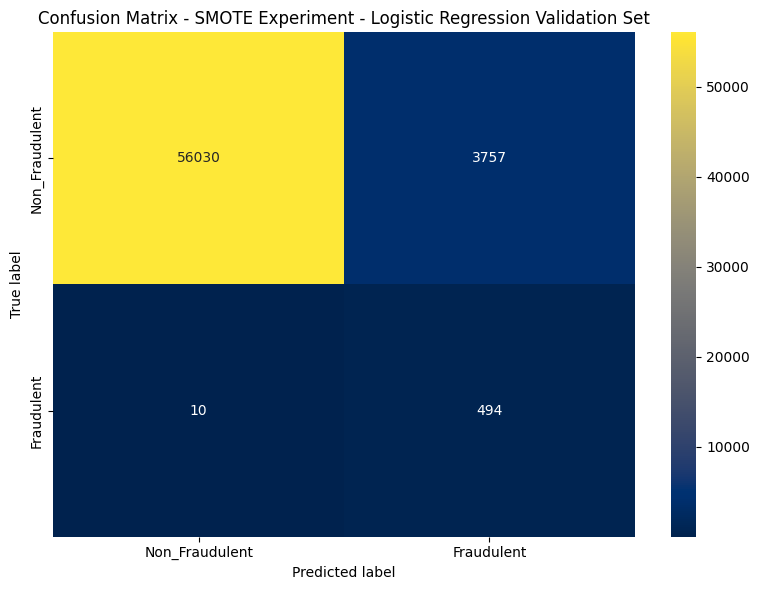

CPU times: user 1.22 s, sys: 11.4 ms, total: 1.23 s
Wall time: 194 ms


In [41]:
%%time

metrics = evaluate_model(
    model=model,
    X=X_val,
    y=y_val,
    name="SMOTE Experiment - Logistic Regression Validation Set"
)

#### 5.2- Evaluation on test set


SMOTE Experiment - Logistic Regression Test Set — metrics

      accuracy: 0.9340
     precision: 0.2163
        recall: 0.9822
            f1: 0.3545
       roc_auc: 0.9921
 avg_precision: 0.8104

Classification report:
               precision    recall  f1-score   support

           0      1.000     0.933     0.965     56678
           1      0.216     0.982     0.354      1066

    accuracy                          0.934     57744
   macro avg      0.608     0.958     0.660     57744
weighted avg      0.985     0.934     0.954     57744



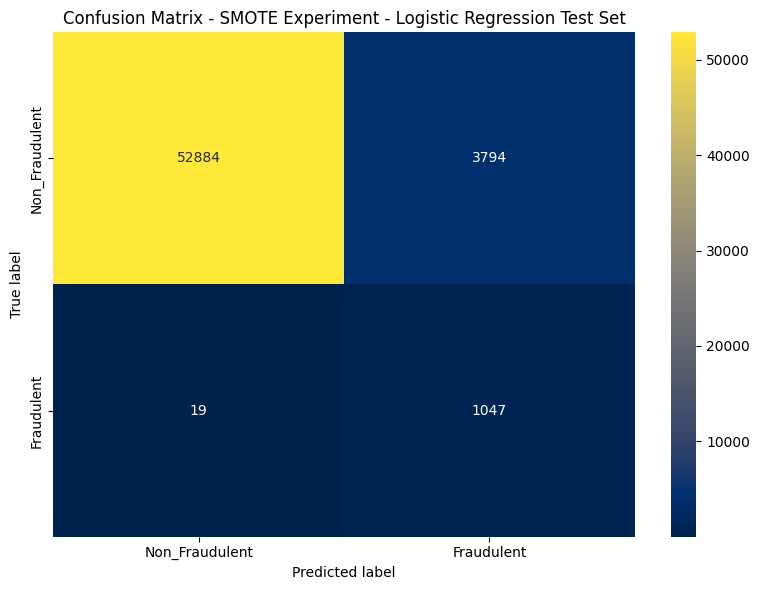

CPU times: user 1.22 s, sys: 0 ns, total: 1.22 s
Wall time: 180 ms


In [42]:
%%time

metrics = evaluate_model(
    model=model,
    X=X_test,
    y=y_test,
    name="SMOTE Experiment - Logistic Regression Test Set"
)

### 6- Feature importances

In [43]:
coefs = model.coef_.ravel()

In [44]:
train_df.columns

Index(['step', 'amount', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'age_5',
       'age_6', 'age_U', 'gender_E', 'gender_F', 'gender_M', 'gender_U',
       'category_es_barsandrestaurants', 'category_es_contents',
       'category_es_fashion', 'category_es_food', 'category_es_health',
       'category_es_home', 'category_es_hotelservices', 'category_es_hyper',
       'category_es_leisure', 'category_es_otherservices',
       'category_es_sportsandtoys', 'category_es_tech',
       'category_es_transportation', 'category_es_travel',
       'category_es_wellnessandbeauty', 'fraud'],
      dtype='object')

In [45]:
feature_importances = pd.DataFrame(
    {
        "feature": X_train.columns,
        "coef": coefs,
        "abs_coef": np.abs(coefs)
    }
).sort_values("abs_coef", ascending=False)

In [46]:
feature_importances

,feature,coef,abs_coef
26,category_es_transportation,-6.100124,6.100124
17,category_es_food,-3.760378,3.760378
24,category_es_sportsandtoys,2.955060,2.955060
22,category_es_leisure,2.192804,2.192804
20,category_es_hotelservices,1.851652,1.851652
23,category_es_otherservices,1.641519,1.641519
1,amount,1.479728,1.479728
15,category_es_contents,-1.310825,1.310825
27,category_es_travel,0.885790,0.885790
18,category_es_health,0.774786,0.774786


### 7- Saving model

In [47]:
joblib.dump(model, "models/smote_model_logistic_regression.joblib")

['models/smote_model_logistic_regression.joblib']